# Transmission and Phase of Huygens' Metasurface

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web
import scienceplots

## 0 Frequency and Wavelength

In [101]:
# Define a FreqRange object with desired wavelengths
fr = td.FreqRange.from_wvl_interval(wvl_min=1.1, wvl_max=1.6)
N = 301 # num_points
freq0 = fr.freq0
lda0 = td.C_0 / fr.freq0

## 1 Computational Domain Size

In [102]:
h = 0.220  # Height of cylinder
spc = 2
Lz = spc + h + h + spc

Px = Py = P = 0.666 # periodicity
sim_size = [Px, Py, Lz]

## 2 Grid Resolution

In [103]:
dl = P / 32
horizontal_grid = td.UniformGrid(dl=dl)
vertical_grid = td.AutoGrid(min_steps_per_wvl=32)
grid_spec=td.GridSpec(
    grid_x=horizontal_grid,
    grid_y=horizontal_grid,
    grid_z=vertical_grid,
)

## 3 Structures and Materials

In [104]:
r = 0.242  # radius of the cylinder
n_Si = 3.5
Si = td.Medium(permittivity=n_Si**2, name='Si')
cylinder = td.Structure(
    geometry=td.Cylinder(center=[0, 0, h / 2], radius=r, length=h, axis=2), medium=Si
)

# Spin_on glass + substrate
n_glass = 1.4
n_SiO2 = 1.45
glass = td.Medium(permittivity=n_glass**2, name='glass')
SiO2 = td.Medium(permittivity=n_SiO2**2, name='oxide')

substrate = td.Structure(
    geometry=td.Box(
        center=(0,0,-Lz/2),
        size=(td.inf,td.inf,2 * (spc+h))
    ),
    medium=SiO2,
    name='substrate'
)

glass = td.Structure(
    geometry=td.Box(
        center=(0,0,Lz/2),
        size=(td.inf,td.inf,2 * (spc+h))
    ),
    medium=glass,
    name='superstrate'
)

# Polymer
n_polymer = 1.66
polymer = td.Structure(
    geometry=td.Box(
        center=(0,0,0),
        size=(td.inf,td.inf,td.inf)
    ),
    medium=td.Medium(permittivity=n_polymer**2, name='polymer'),
    name='polymer'
)

## 4 Sources

In [111]:
source = td.PlaneWave(
    source_time=fr.to_gaussian_pulse(),
    size=(td.inf, td.inf, 0),
    center=(0, 0, Lz/2 - spc + 0.5 * lda0),
    direction="-",
    pol_angle=0
)

## 5 Monitors

In [112]:
flux_monitor = td.FluxMonitor(
    center=(0, 0, -Lz/2 + spc - 0.5 * lda0),
    size=(td.inf, td.inf, 0),
    freqs=fr.freqs(N),
    name="flux monitor"
)

# DiffractionMonitor only gives you amplitudes of diffraction orders, 
# losing phase detail if you care about continuous phase.
field_monitor = td.FieldMonitor(
    center=(0, 0, -Lz/2 + spc - 0.5 * lda0),
    size=(td.inf, td.inf, 0),
    fields=["Ex"],
    freqs=fr.freqs(N),
    name="field monitor"
)



## 6 Run Time

In [113]:
bandwidth = fr.fmax - fr.fmin
run_time= 50 / bandwidth

## 7 Boundary Conditions

In [114]:
bc = td.BoundarySpec(
    x=td.Boundary.periodic(), 
    y=td.Boundary.periodic(), 
    z=td.Boundary.pml()
)

## 8 Define Simulation


In [115]:
sim_empty=td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[substrate, glass],
    sources=[source],
    monitors=[flux_monitor, field_monitor],
    run_time=run_time,
    boundary_spec=bc
)

sim_actual = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[substrate, glass, cylinder],
    sources=[source],
    monitors=[flux_monitor, field_monitor],
    run_time=run_time,
    boundary_spec=bc
)

## 9 Visualization

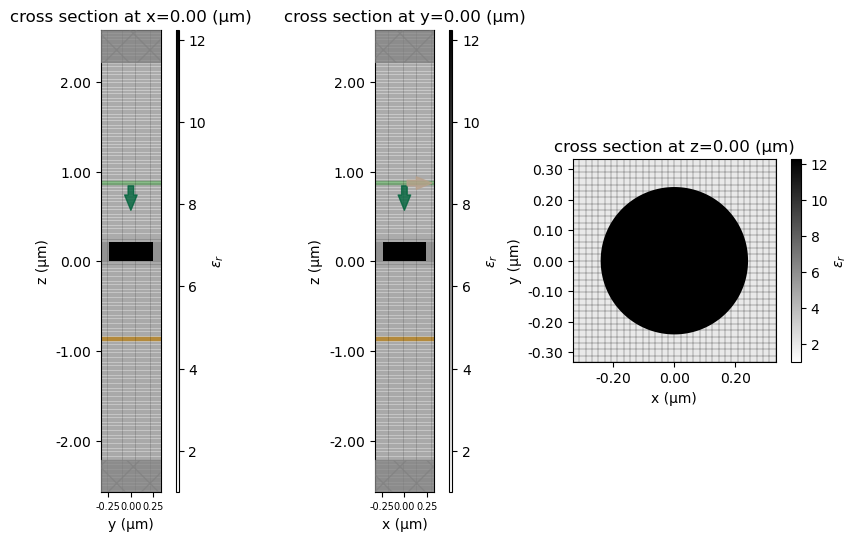

In [116]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(10, 6))
ax1.tick_params(axis='x', labelsize=7)
ax2.tick_params(axis='x', labelsize=7)
sim_actual.plot_eps(x=0, ax=ax1)
sim_actual.plot_grid(x=0, ax=ax1)
sim_actual.plot_eps(y=0, ax=ax2)
sim_actual.plot_grid(y=0, ax=ax2)
sim_actual.plot_eps(z=0, ax=ax3)
sim_actual.plot_grid(z=0, ax=ax3)
plt.savefig('huygens_structure.png', dpi=300)

## 10 Run the Simulation

In [117]:
sims = {
    "norm": sim_empty,
    "actual": sim_actual,
}

batch = web.Batch(simulations=sims, verbose=True)
batch_data = batch.run(path_dir="data")

Output()

22:17:35 EDT Started working on Batch containing 2 tasks.

22:17:37 EDT Maximum FlexCredit cost: 0.050 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

22:17:49 EDT Batch complete.

Output()

## 11 Postprocess

### Transmission

In [125]:
# this uses scienceplots to make plots look better
plt.style.use(['science', 'notebook', 'grid'])

In [120]:
T = batch_data["actual"]["flux monitor"].flux / batch_data["norm"]["flux monitor"].flux

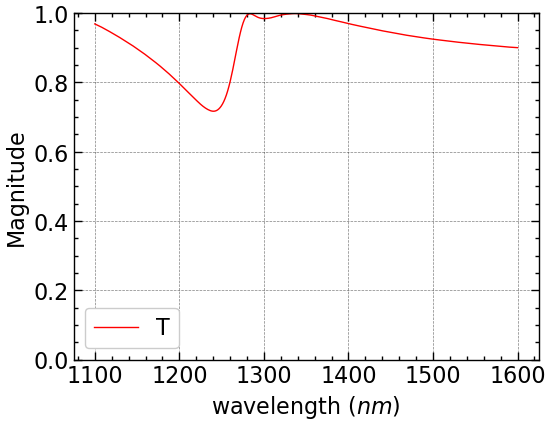

In [157]:
# plot transmission, compare to paper results, look similar
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
plt.plot(td.C_0 / fr.freqs(N) * 1000, T, "r", lw=1, label="T")
plt.xlabel(r"wavelength ($nm$)")
plt.ylabel("Magnitude")
plt.ylim(0, 1)
plt.legend()
plt.show()

### Phase

In [184]:
Ex_actual = batch_data["actual"]["field monitor"].Ex 
Ex_norm = batch_data["norm"]["field monitor"].Ex
Ex = Ex_actual / Ex_norm

In [190]:
# 1. Compute average over the xy-plane
Ex_avg = np.mean(Ex[:, :, 0, :], axis=(0,1))

# 2. Compute phase
phase_avg = np.angle(Ex_avg)

# 3. Unwrap phase to remove ±pi jumps
phase_avg_unwrapped = np.unwrap(phase_avg)

# 4. Make relative to first point (optional)
phase_rel = phase_avg_unwrapped - phase_avg_unwrapped[0]

phase_actual = np.unwrap(np.angle(np.mean(Ex_actual[:, :, 0, :], axis=(0,1))))
phase_norm = np.unwrap(np.angle(np.mean(Ex_norm[:, :, 0, :], axis=(0,1))))

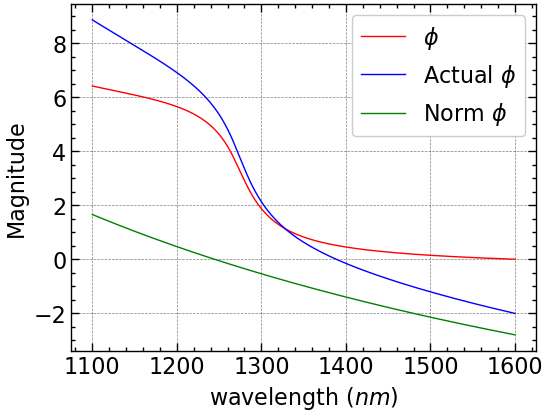

In [193]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
plt.plot(td.C_0 / fr.freqs(N) * 1000, phase_rel, "r", lw=1, label="$\phi$")
plt.plot(td.C_0 / fr.freqs(N) * 1000, phase_actual, "b", lw=1, label="Actual $\phi$")
plt.plot(td.C_0 / fr.freqs(N) * 1000, phase_norm, "g", lw=1, label="Norm $\phi$")
plt.xlabel(r"wavelength ($nm$)")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

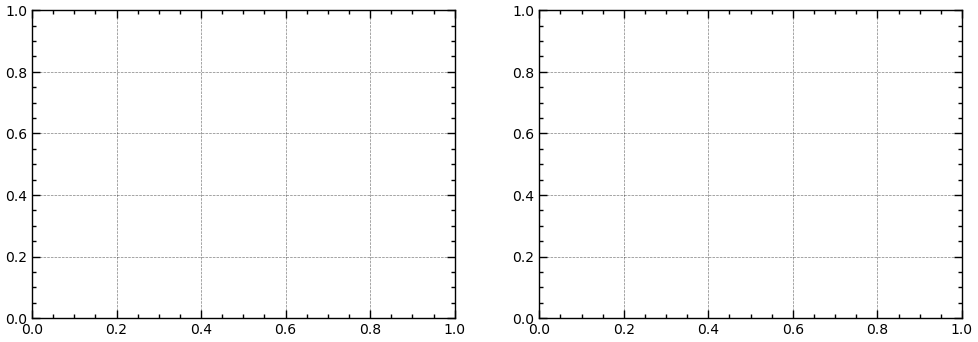

In [209]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# work on the first figure
ax = axes[0]
ax.tick_params(axis="both", labelsize=10)

# work on the second figure
ax = axes[1]
ax.tick_params(axis="both", labelsize=10)